<a href="https://colab.research.google.com/github/HarshilShah1804/ES335_Assignment2/blob/main/Task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Generic Matrix Factorization (without missing values)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from einops import rearrange


Let us decompose A as WH. W is of shape (n, k) and H is of shape (k, n). We can write the above equation as:
A = WH

In [3]:
# Randomly initialize A and B

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
# Modify the loss function to ignore NaN values

def factorize(A, k, iter=1000,  device=torch.device("cpu")):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)

    #storing the losses
    loss_arr = []

    # Train the model
    for i in range(iter):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)

        if i % 10 == 0:
            loss_arr.append(loss.item())

        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()

    return W, H, loss, loss_arr

In [5]:
# Image completion
import os
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [6]:
# Read in a image from torchvision
import torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


In [7]:
# Make grayscale
img = torch.tensor(img, dtype=torch.float)
img = img.mean(dim=0, keepdim=False)
print(img.shape)

torch.Size([1365, 2048])


<ipython-input-7-1bc2d42b11f4>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float)


In [8]:
img.shape

torch.Size([1365, 2048])

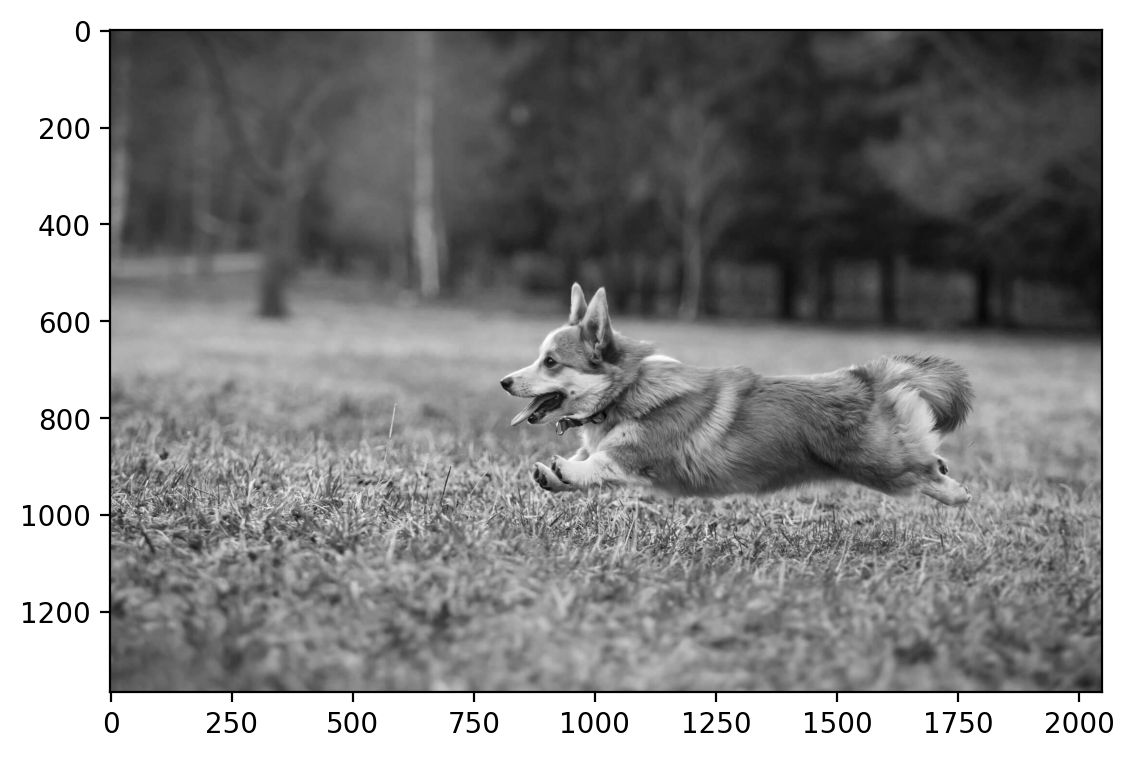

In [9]:
plt.imshow(img, cmap='gray')

In [11]:
crop = torchvision.transforms.functional.crop(img, 600, 800, 300, 300)
crop.shape

torch.Size([300, 300])

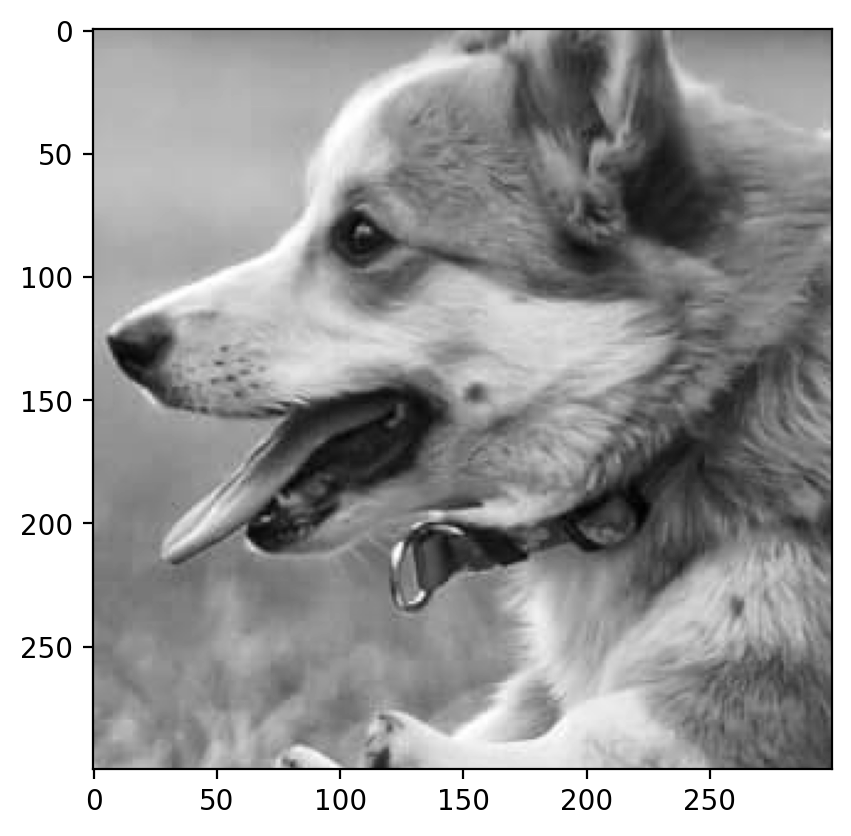

In [12]:
plt.imshow(crop, cmap='gray')

In [13]:
# Mask the image with NaN values
def mask_image(img, prop):
    img_copy = img.clone()
    mask = torch.rand(img.shape) < prop
    img_copy[mask] = float('nan')
    return img_copy, mask

In [14]:
masked_img = mask_image(crop, 0.3)


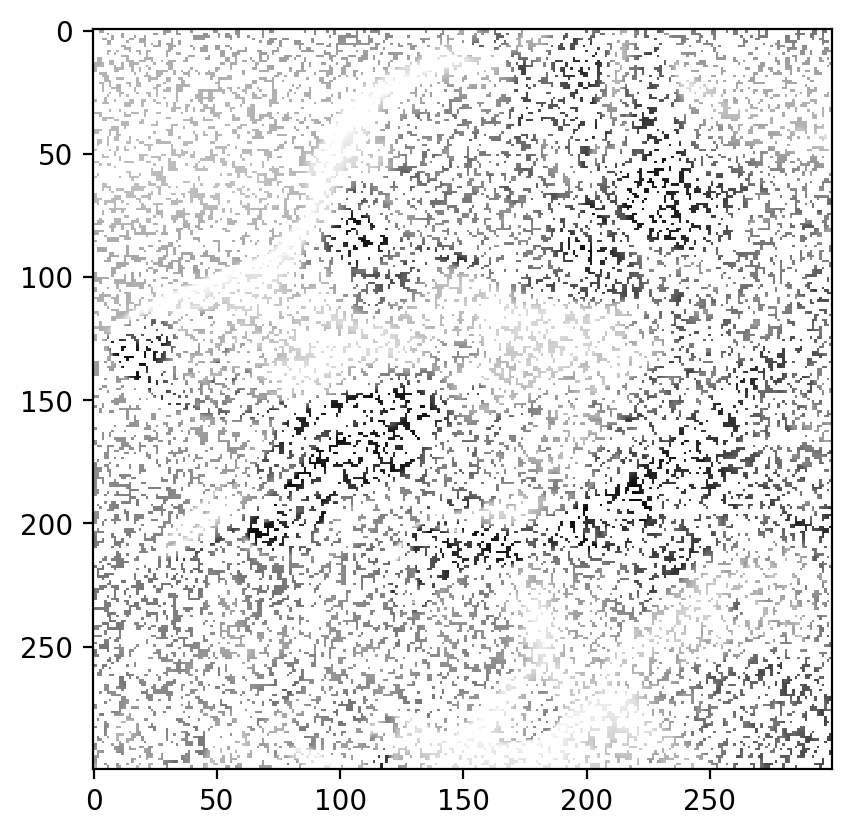

In [15]:
plt.imshow(masked_img[0], cmap='gray')

In [16]:
W, H, loss, loss_arr = factorize(masked_img[0], 50, 1000, device=device)

In [17]:
loss

tensor(1357.0195, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

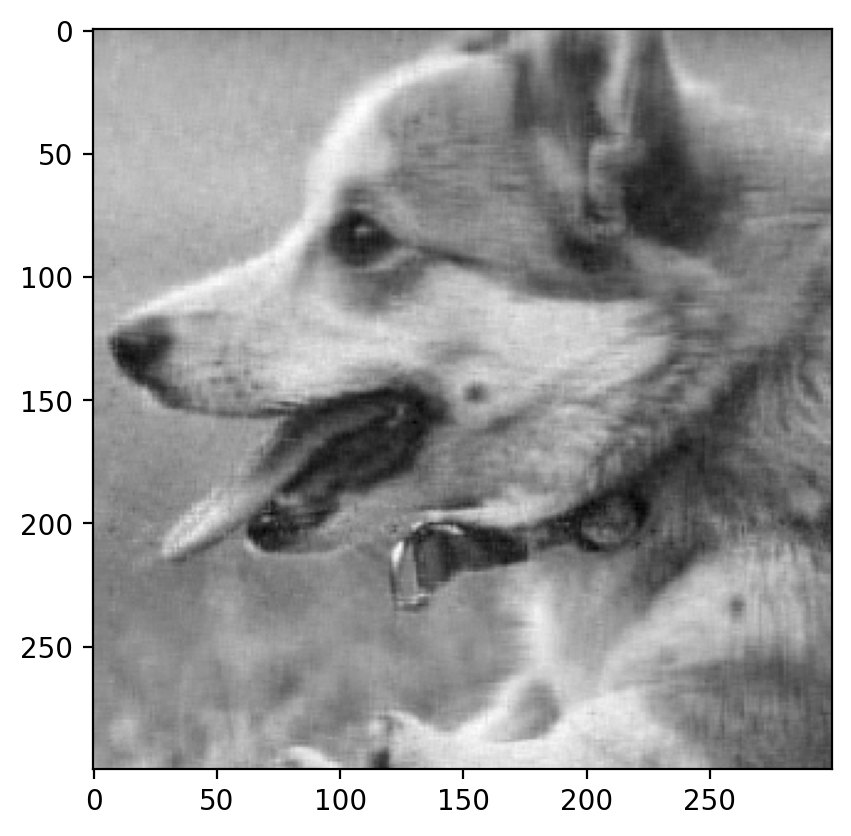

In [18]:
plt.imshow(torch.mm(W, H).cpu().detach().numpy(), cmap='gray')

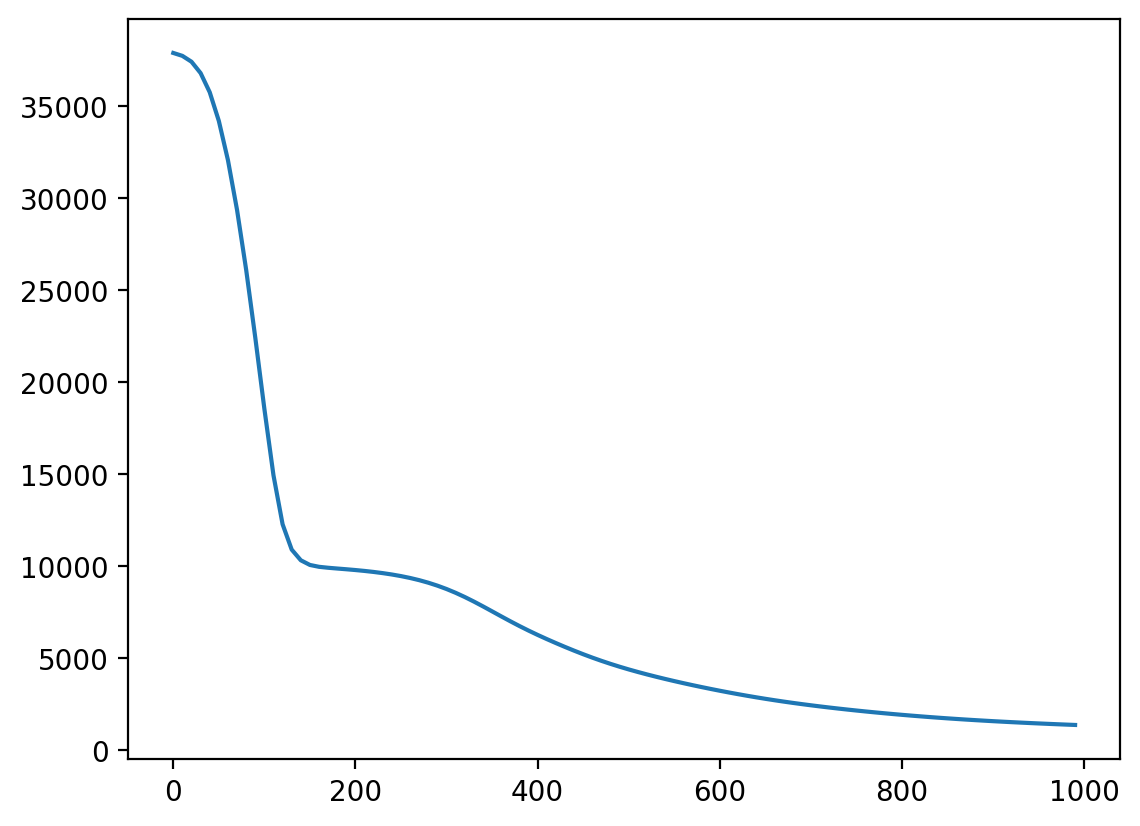

In [19]:
plt.plot(np.arange(0, 1000, 10), loss_arr)

In [20]:
def plot_image_completion(prop=0.1, factors=50):
    masked_img, mask = mask_image(crop, prop)
    W, H, loss, loss_arr = factorize(masked_img, factors, 1000, device=device)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    reconstructed_img = torch.mm(W, H).cpu().detach().numpy()
    ax[0].imshow(masked_img, cmap='gray')
    ax[0].set_title("Masked image")
    ax[1].imshow(reconstructed_img, cmap='gray')
    ax[1].set_title("Reconstructed image")
    ax[2].imshow(crop, cmap='gray')
    ax[2].set_title("Original image")
    rmse = calculate_rmse(crop, reconstructed_img)
    print("RMSE: ", rmse)
    print("PSNR: ", calculate_psnr(crop.max(), rmse))

In [21]:
# calculate the rmse
def calculate_rmse(original_values, predicted_values):
    return np.sqrt(((original_values - predicted_values) ** 2).mean())

In [22]:
#calculate the psnr
def calculate_psnr(maximum, rmse):
    return 10 * np.log10(maximum**2 / rmse)

RMSE:  tensor(27.3446)
PSNR:  tensor(33.7621)


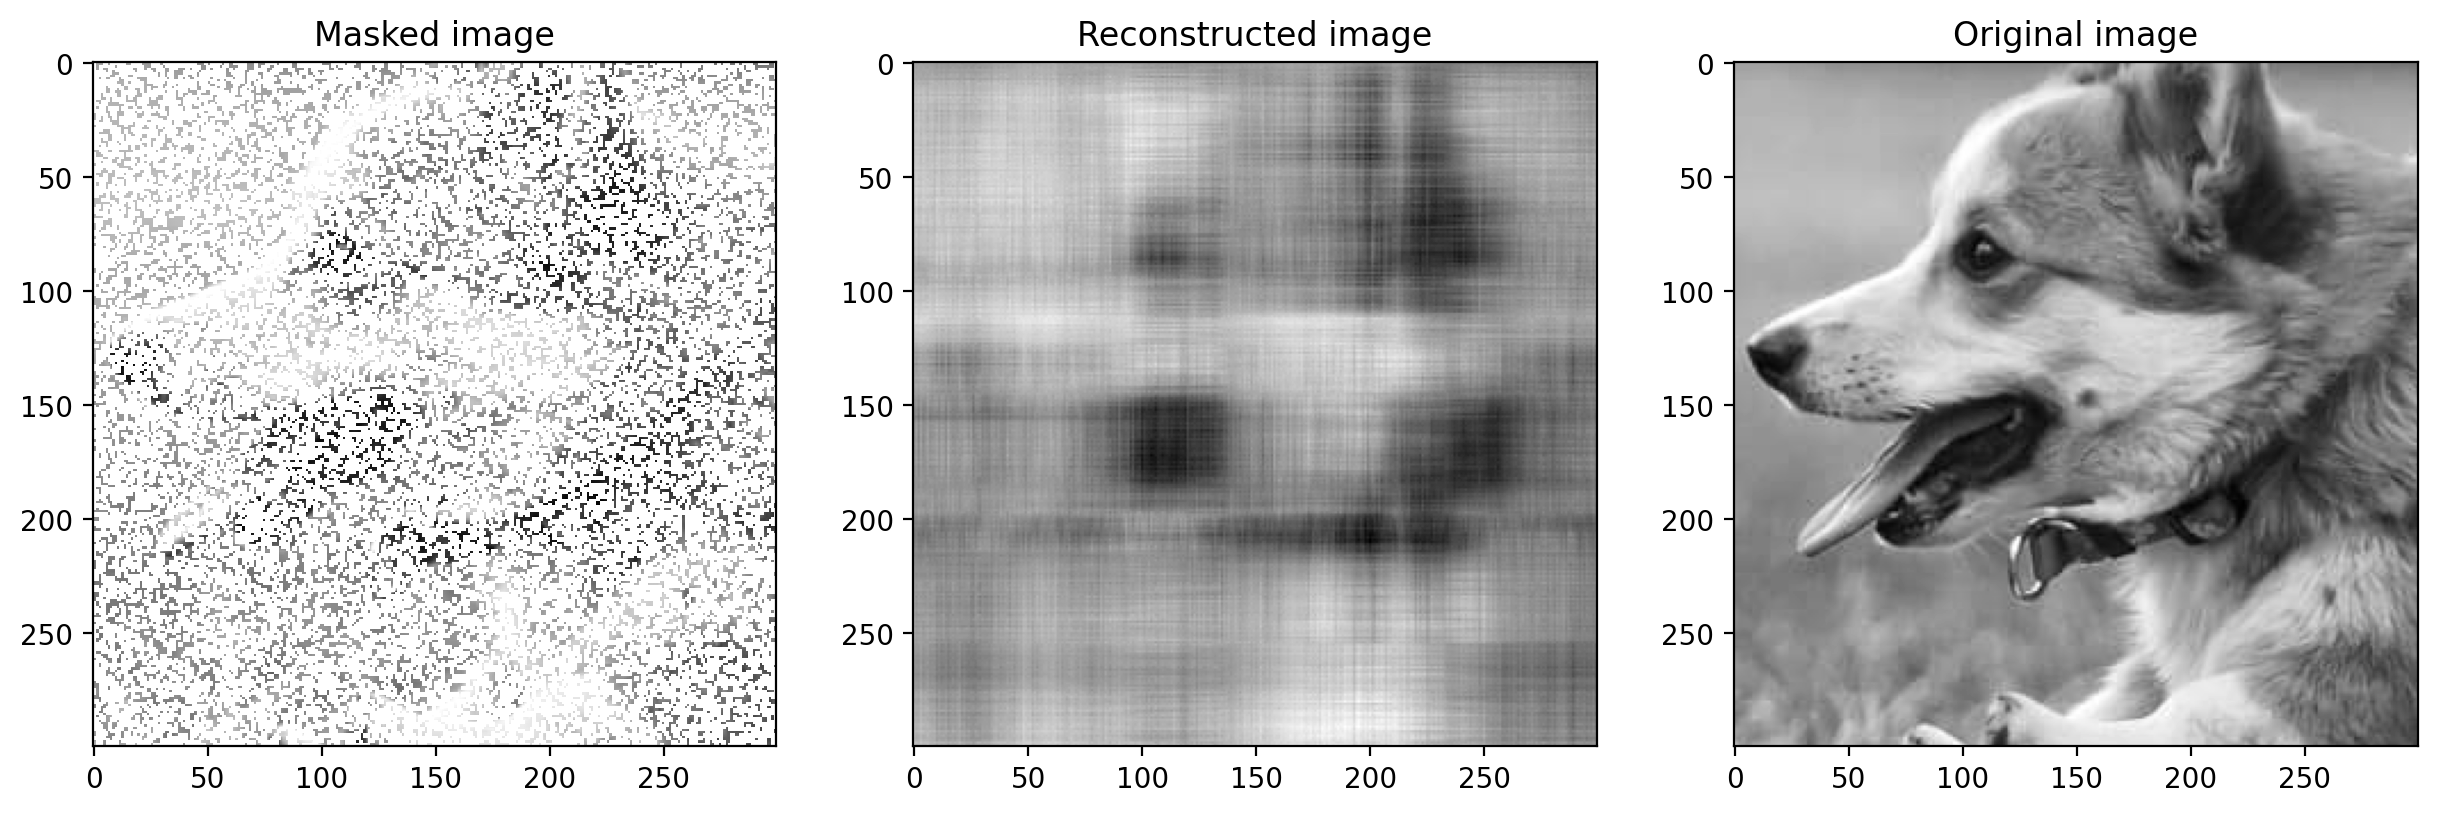

In [23]:
# for r = 10
plot_image_completion(prop=0.3, factors=10)

RMSE:  tensor(10.8907)
PSNR:  tensor(37.7602)


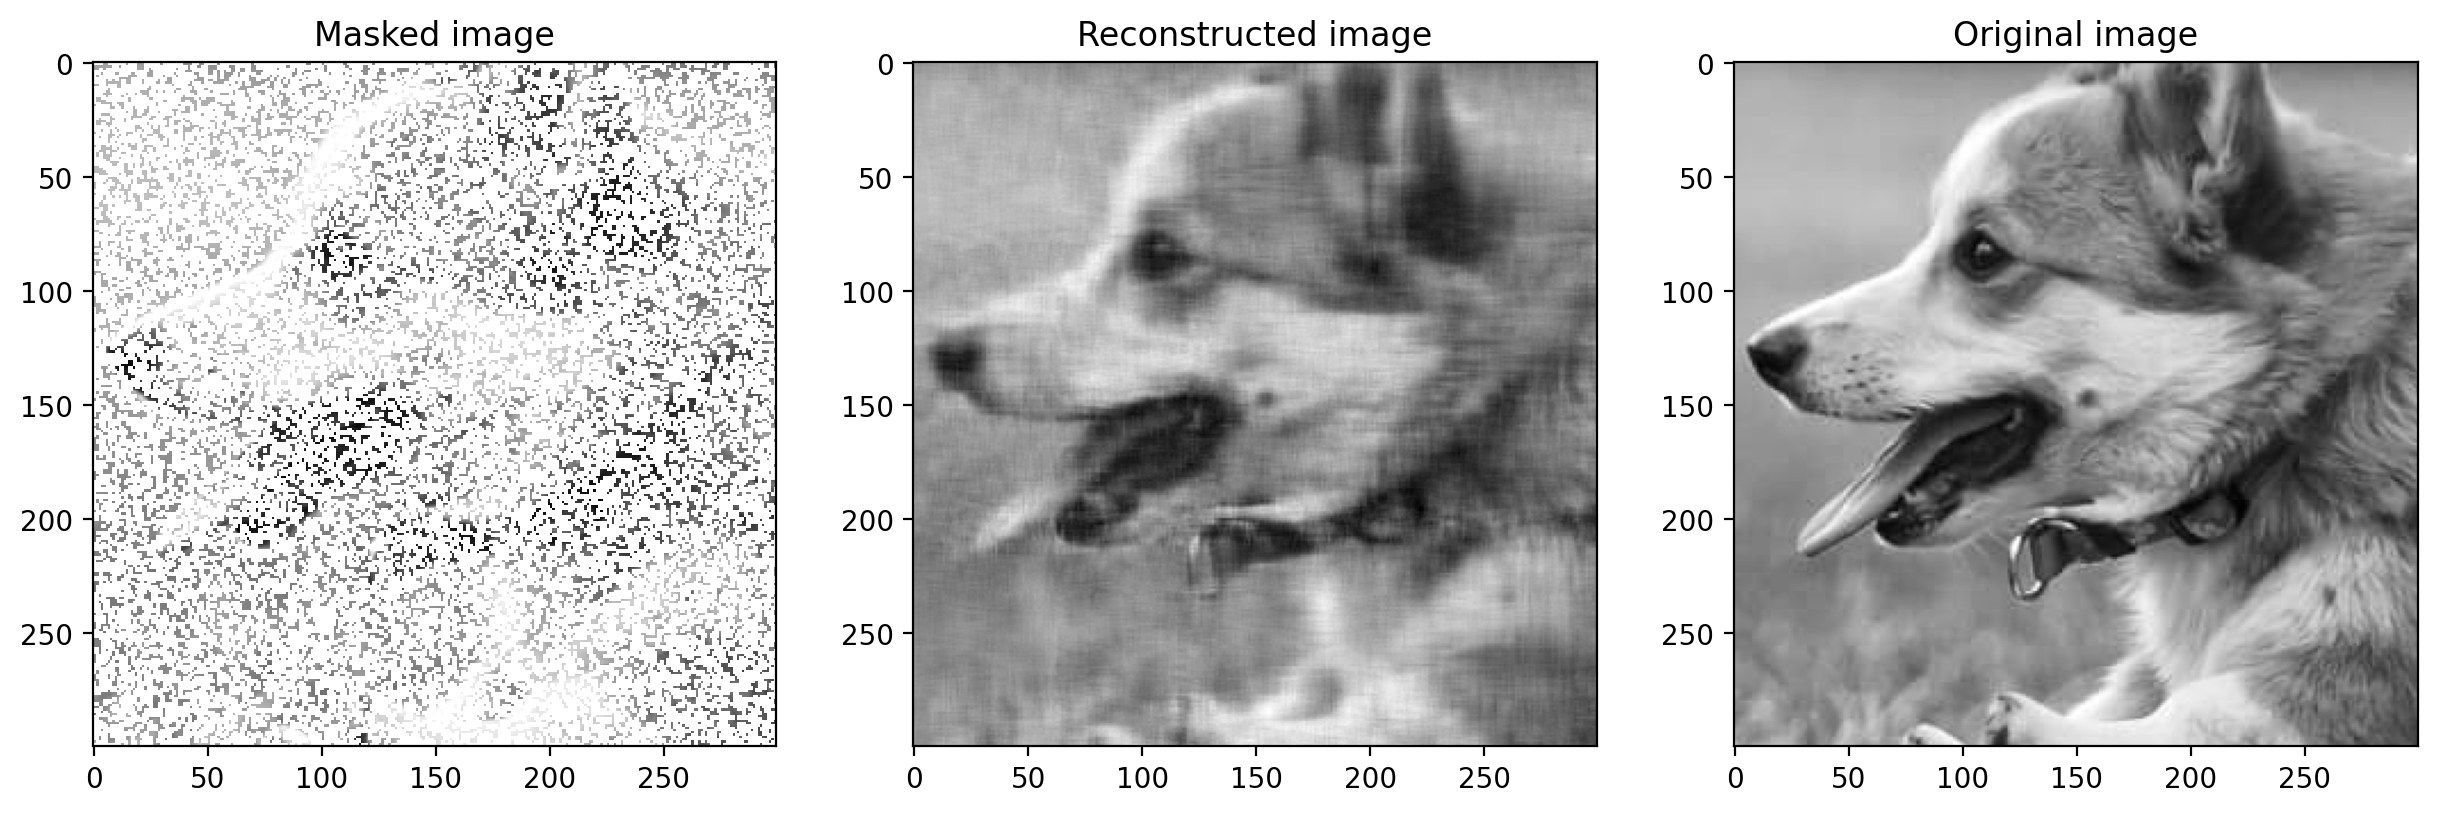

In [24]:
# for r = 30
plot_image_completion(prop=0.3, factors=30)

RMSE:  tensor(7.0475)
PSNR:  tensor(39.6505)


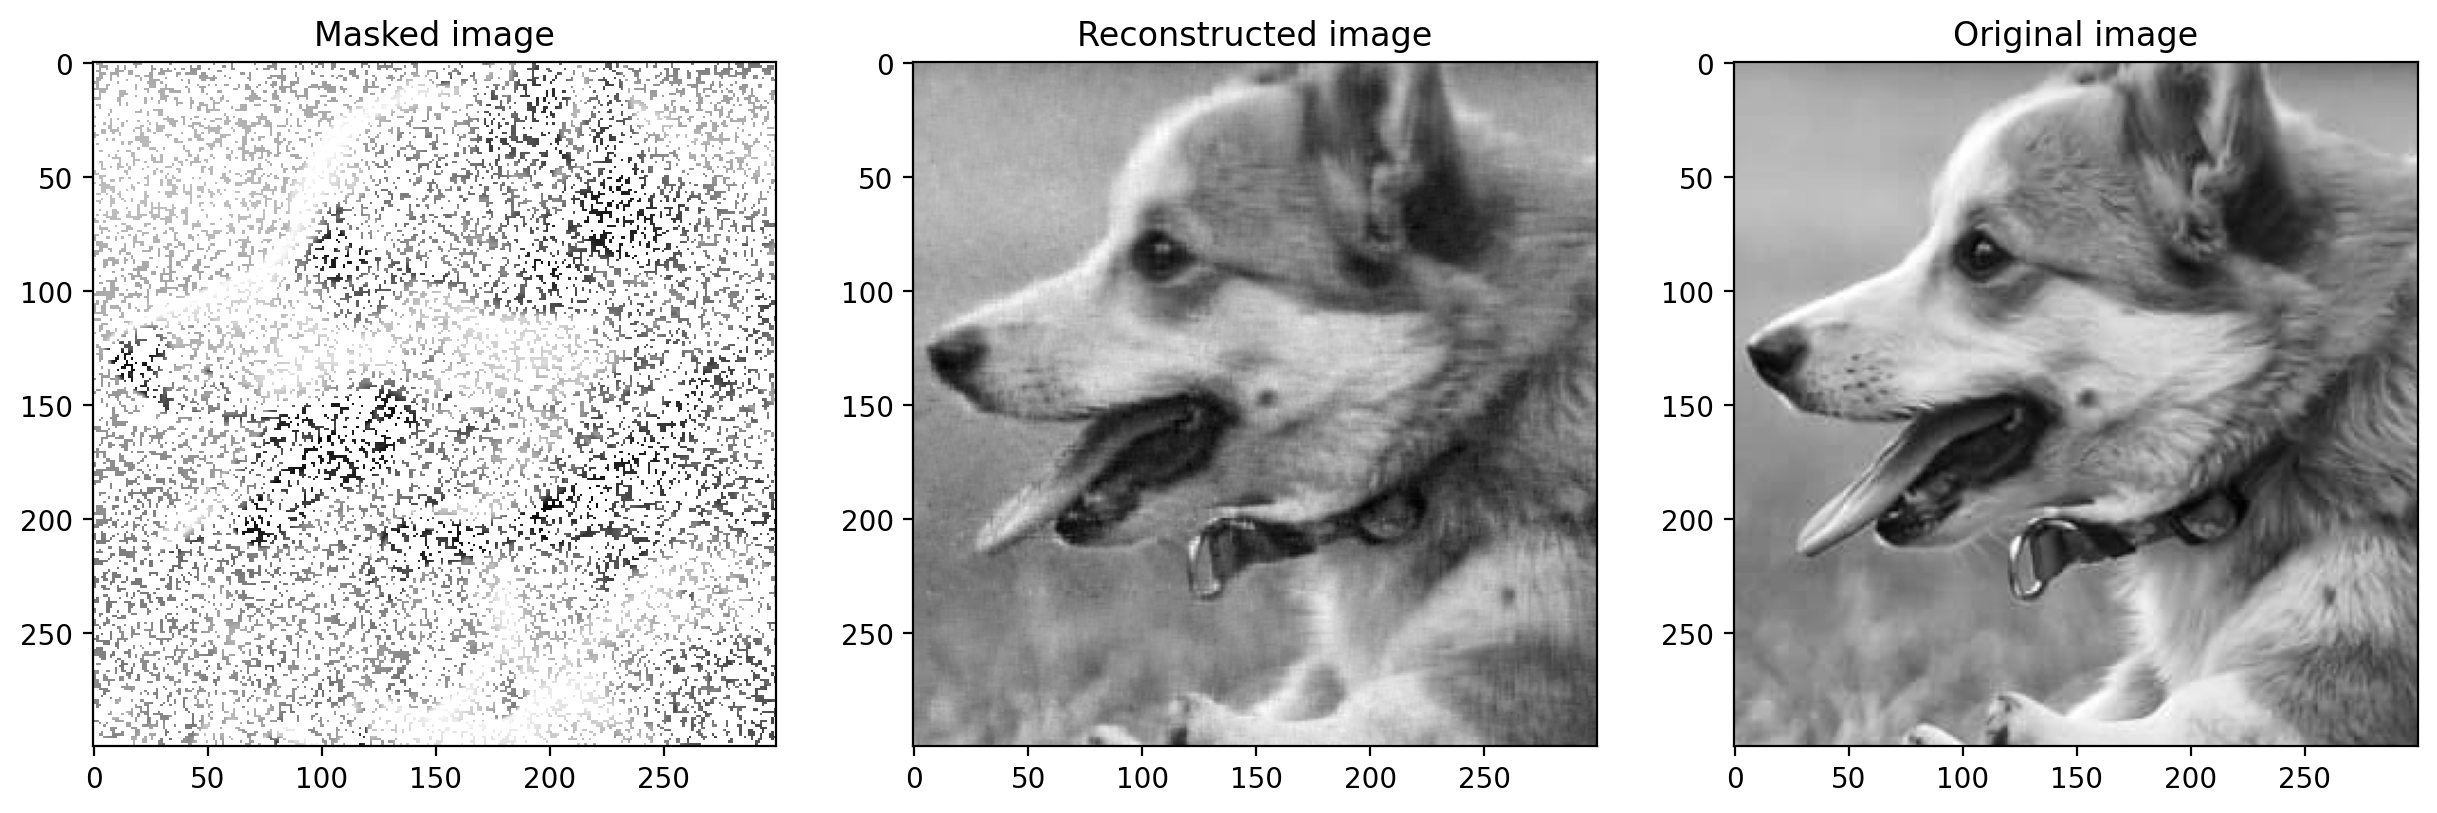

In [25]:
# for r = 50
plot_image_completion(prop=0.3, factors=50)

RMSE:  tensor(5.5864)
PSNR:  tensor(40.6595)


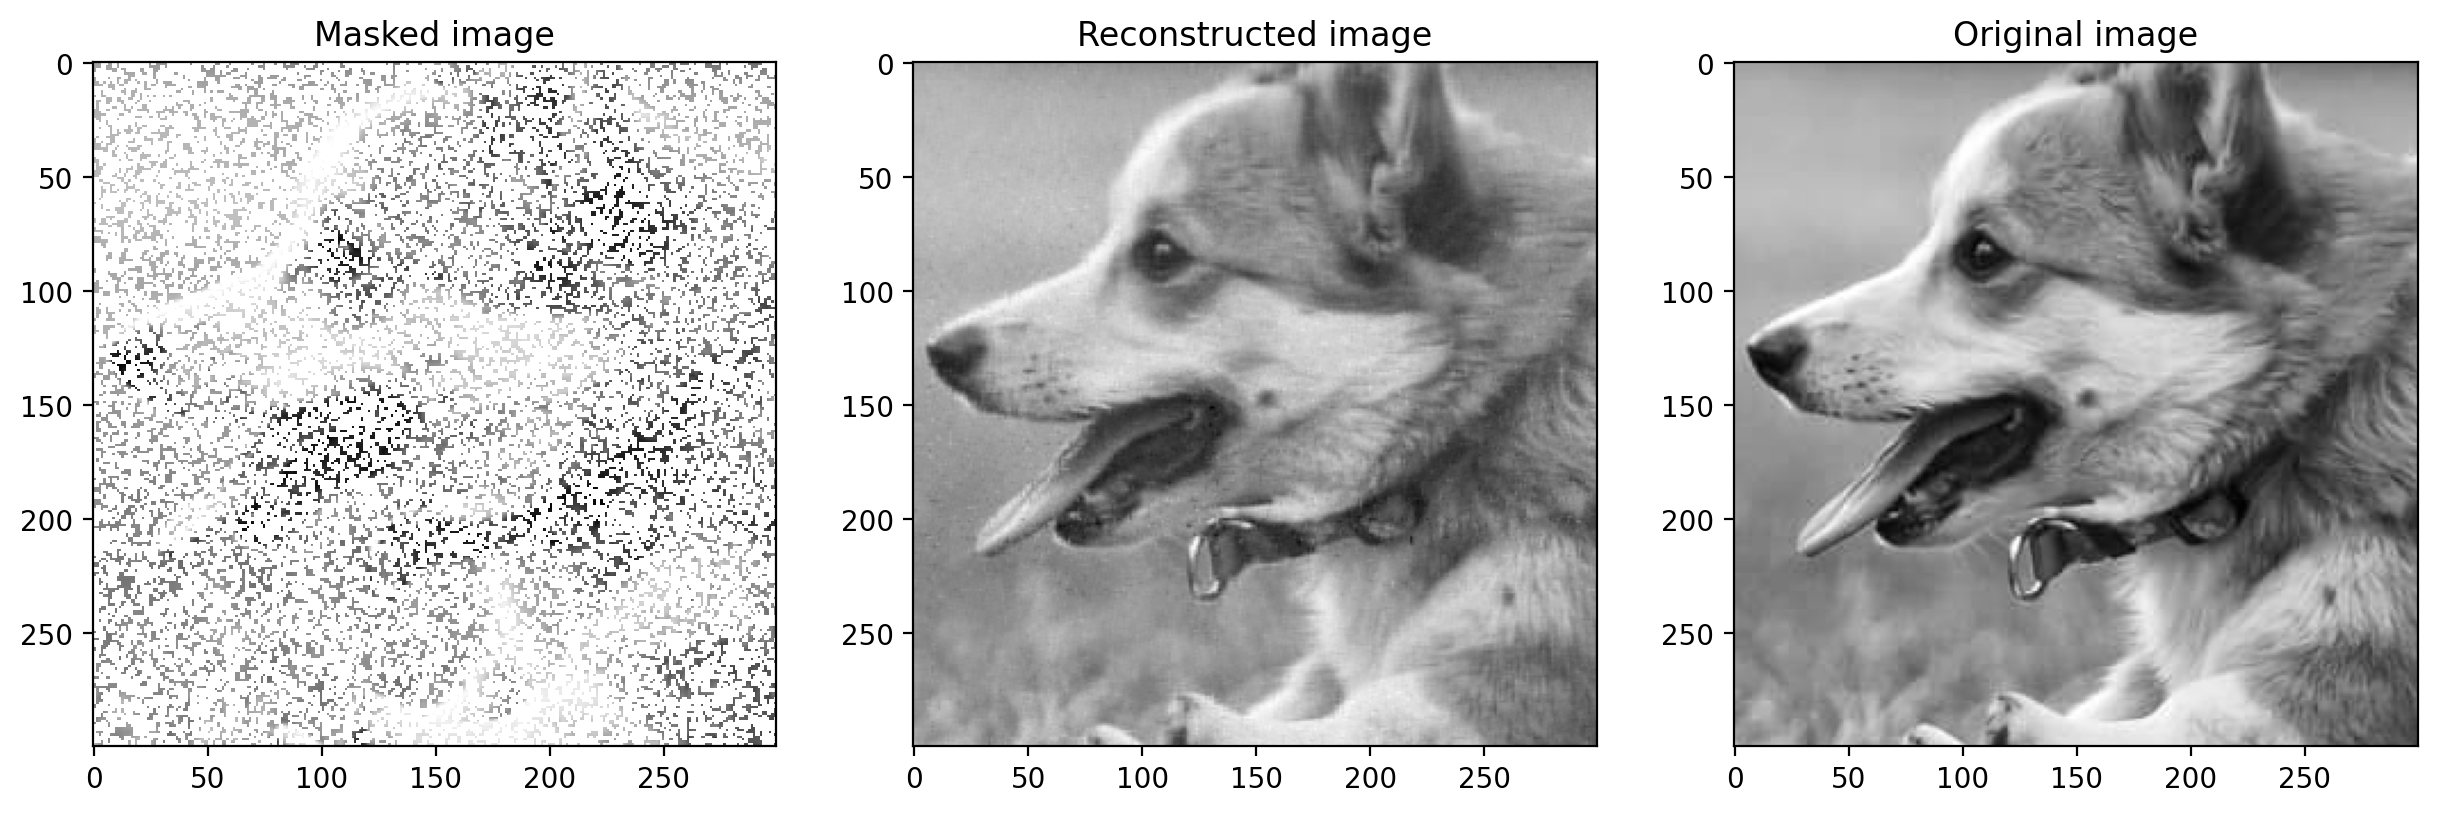

In [26]:
# for r = 70
plot_image_completion(prop=0.3, factors=70)

RMSE:  tensor(5.2479)
PSNR:  tensor(40.9310)


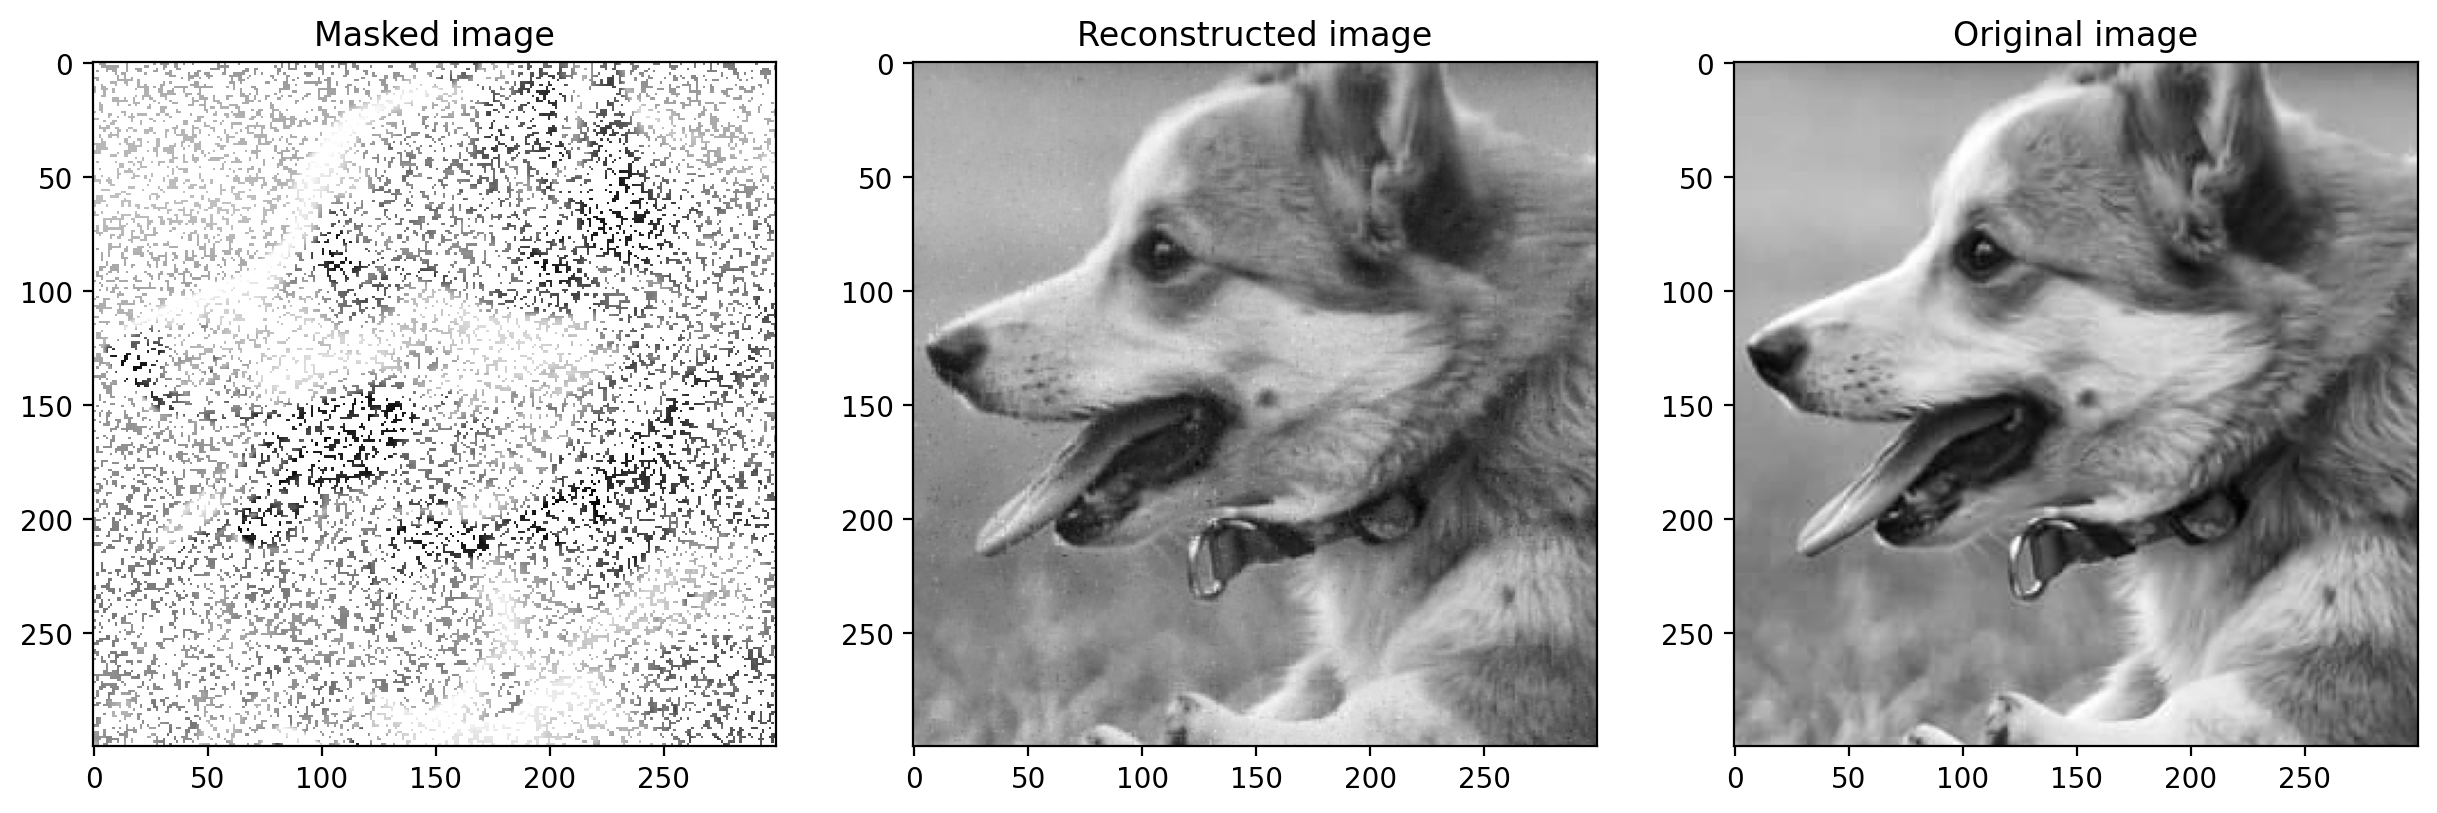

In [27]:
# for r = 90
plot_image_completion(prop=0.3, factors=90)

## Question 2


In [28]:
def remove_random(image_array):
  """
  Return type: ndarray
  This function removes the random block of 30 * 30 pixels from the image.
  """
  image_array = image_array.clone()
  # Define the size of the block to remove
  block_size = 30

  # Choose a random starting point for the block
  x_start = np.random.randint(0, image_array.shape[0] - block_size + 1)
  y_start = np.random.randint(0, image_array.shape[1] - block_size + 1)

  # Set the 30x30 block to zeros (or another value to represent removal)
  image_array[x_start:x_start + block_size, y_start:y_start + block_size] = 255
  return image_array

In [29]:
def plot_image_missingBlock(image_array, factors=50):
    W, H, loss, loss_arr = factorize(image_array, factors, 1000, device=device)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    reconstructed_img = torch.mm(W, H).cpu().detach().numpy()
    ax[0].imshow(image_array, cmap='gray')
    ax[0].set_title("Masked image")
    ax[1].imshow(reconstructed_img, cmap='gray')
    ax[1].set_title("Reconstructed image")
    ax[2].imshow(crop, cmap='gray')
    ax[2].set_title("Original image")
    rmse = calculate_rmse(crop, reconstructed_img)
    print("RMSE: ", rmse)
    print("PSNR: ", calculate_psnr(crop.max(), rmse))

RMSE:  tensor(16.5008)
PSNR:  tensor(35.9558)


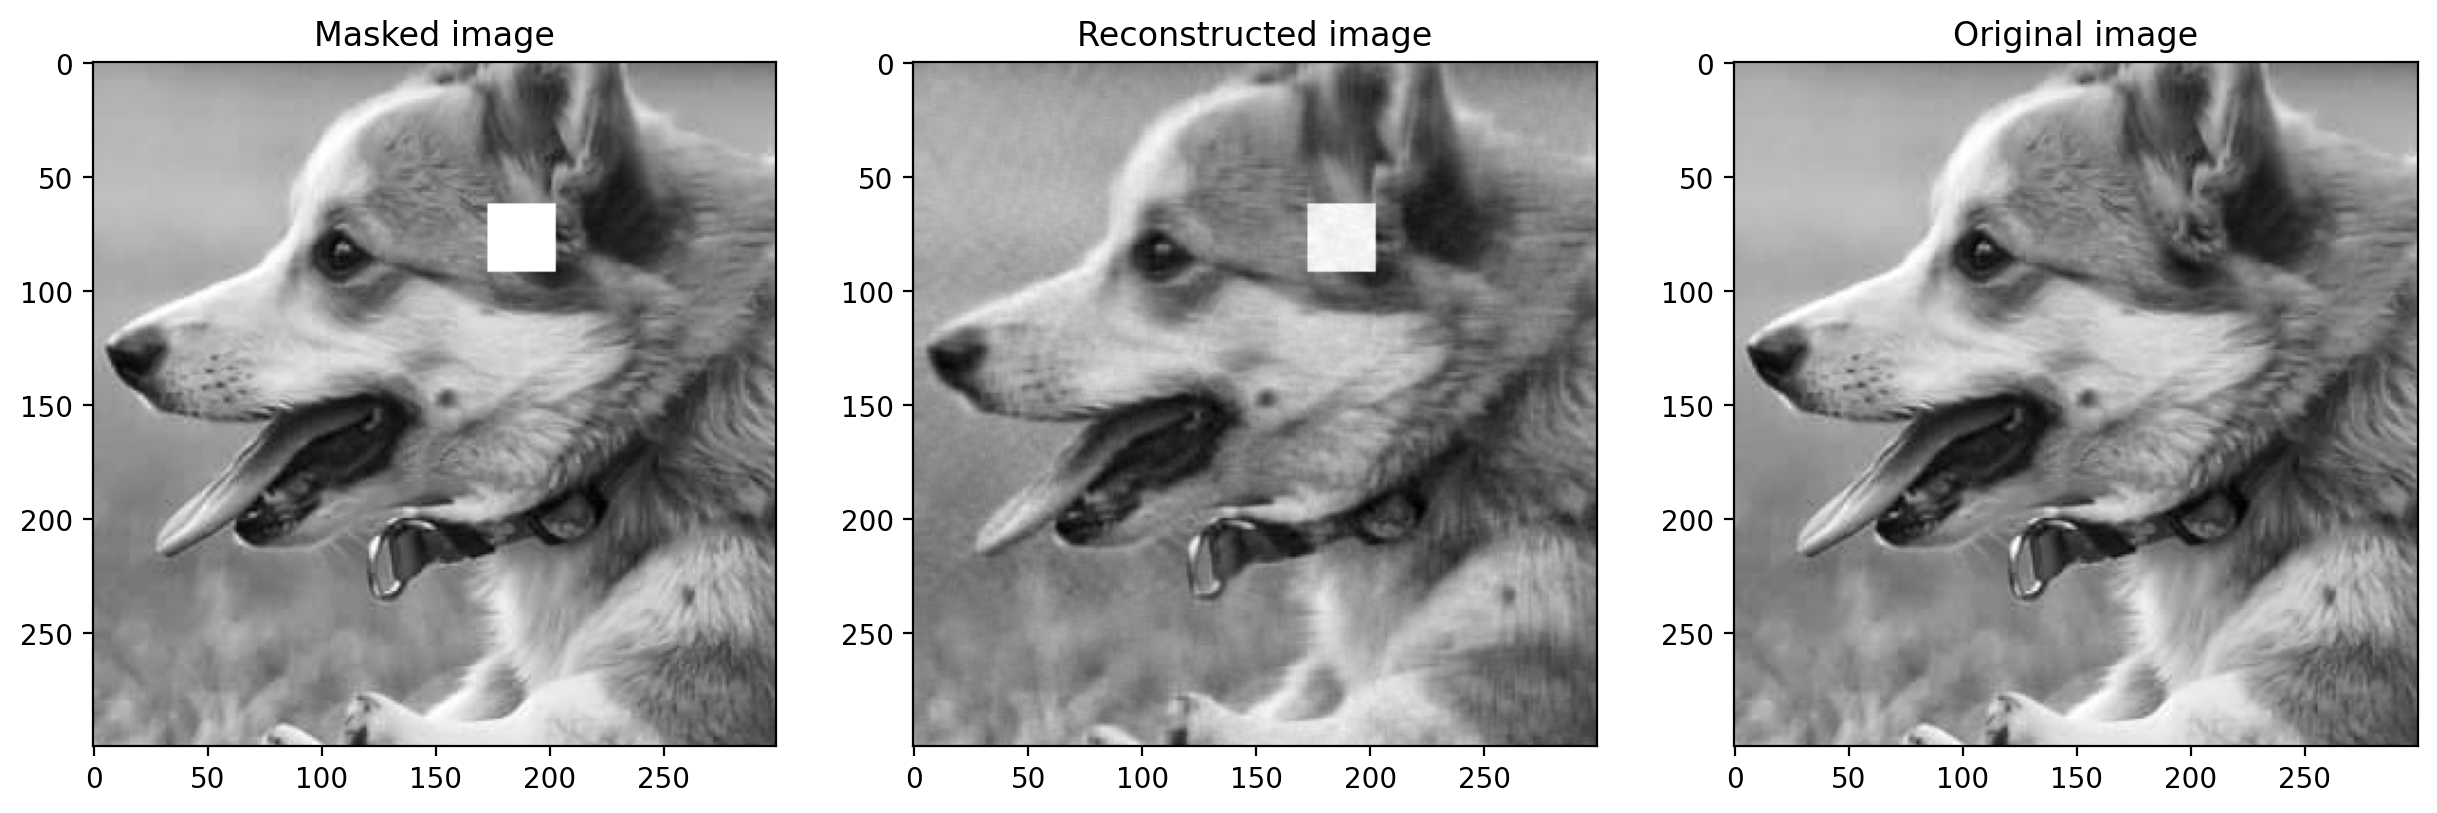

In [30]:
removed_image = remove_random(crop)
plot_image_missingBlock(removed_image, factors=50)

RMSE:  tensor(18.6896)
PSNR:  tensor(35.4148)


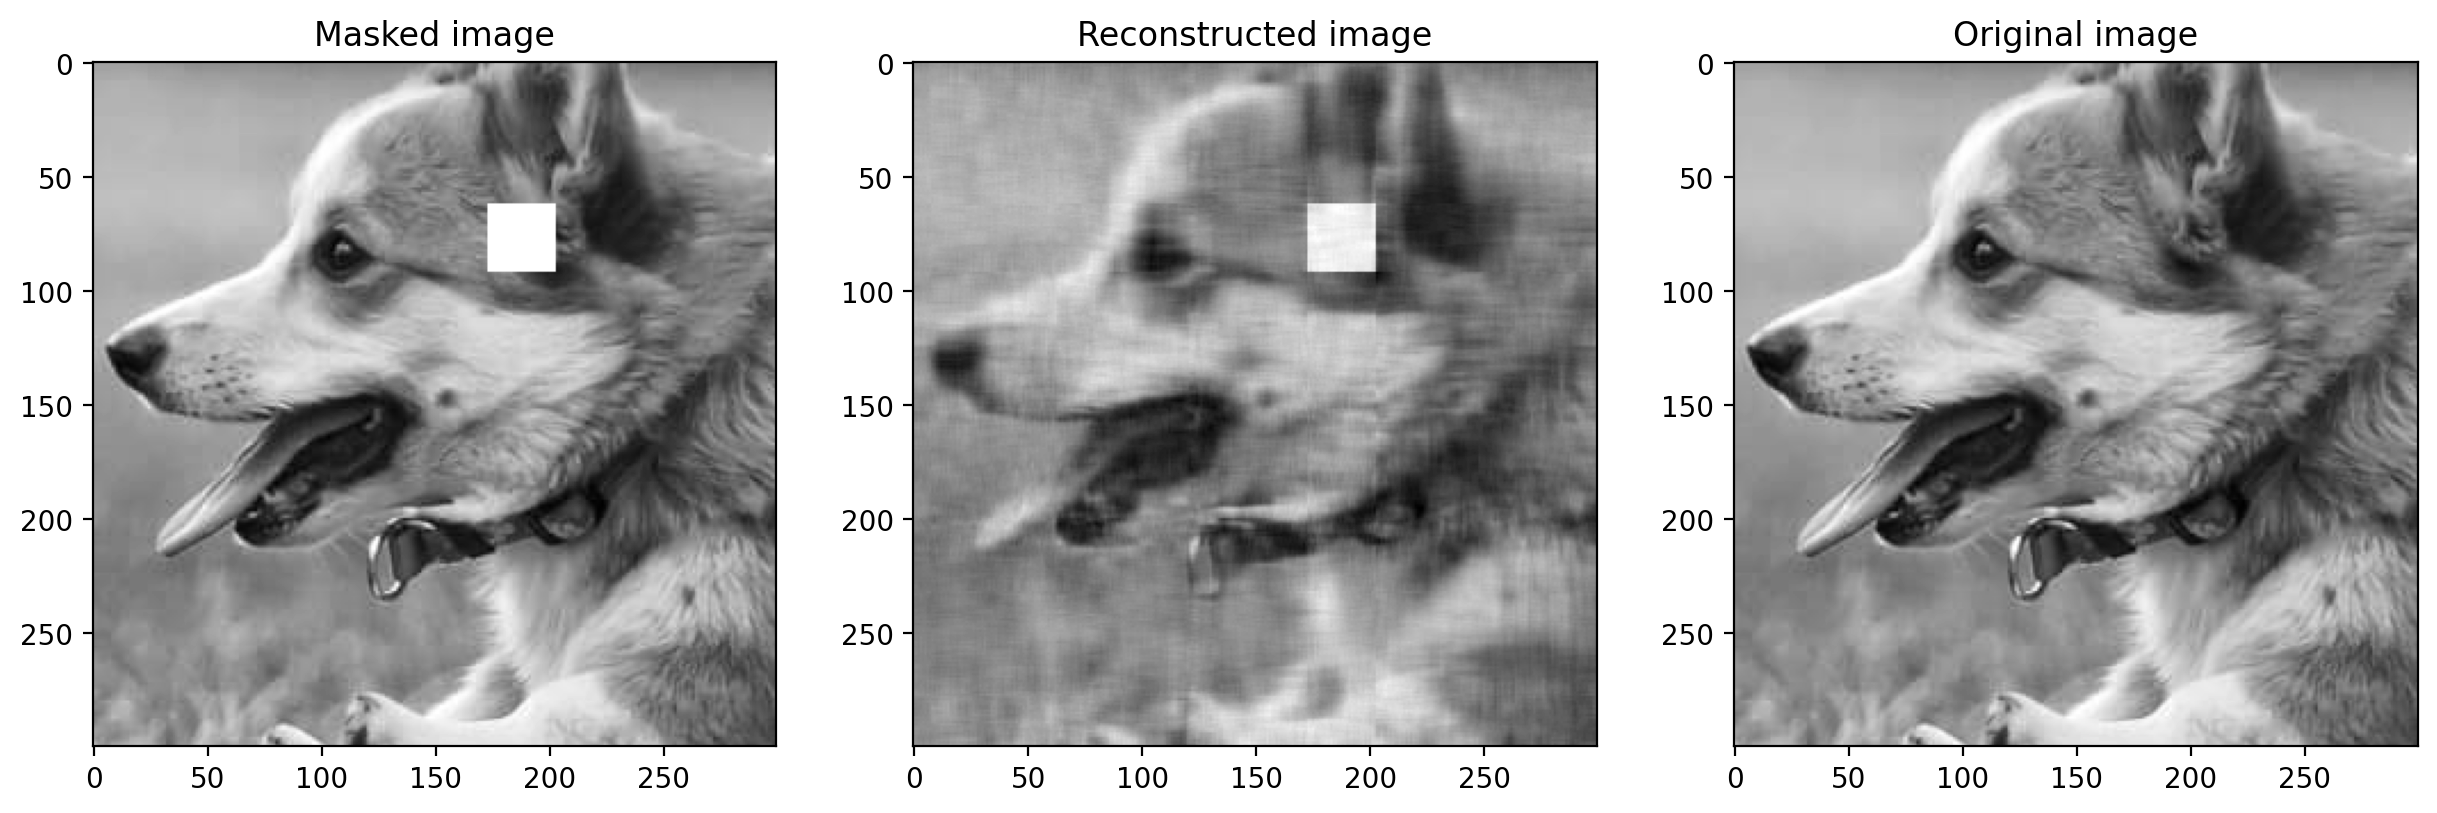

In [31]:
plot_image_missingBlock(removed_image, factors=30)

RMSE:  tensor(15.9023)
PSNR:  tensor(36.1162)


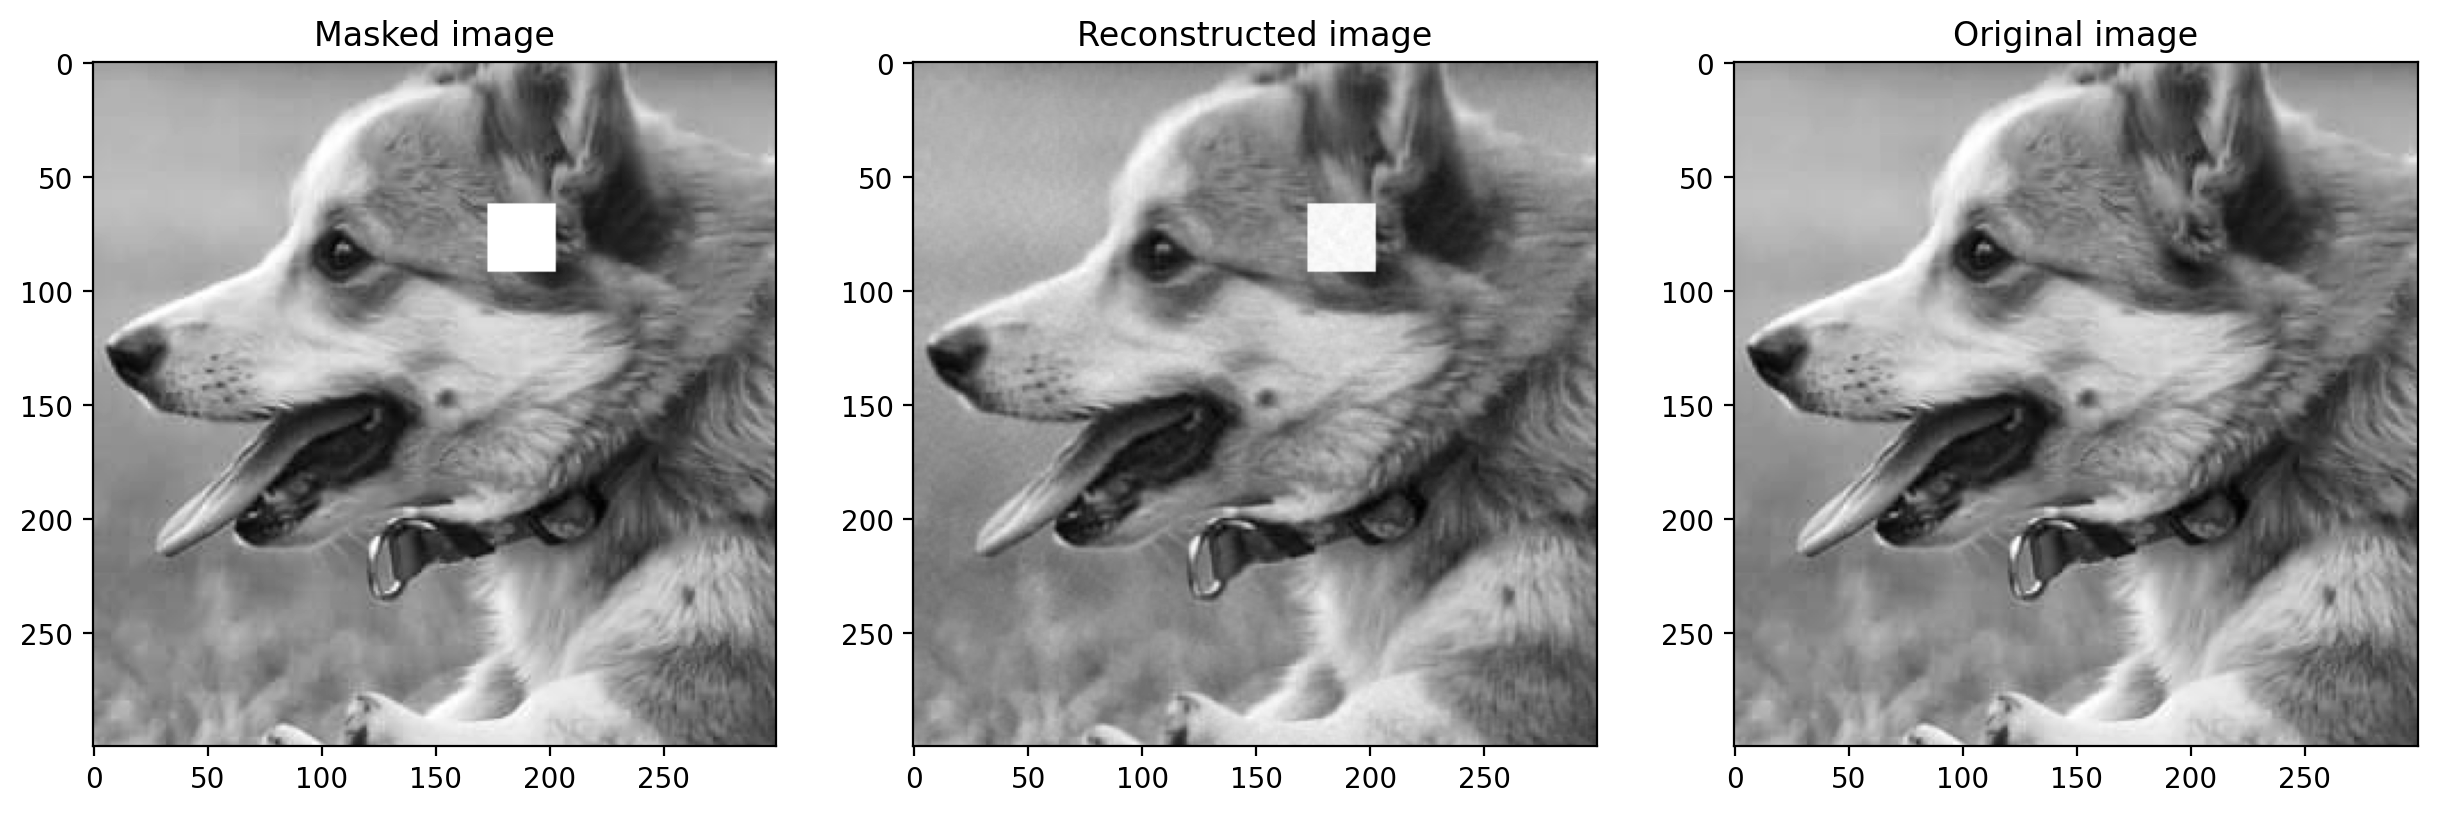

In [32]:
plot_image_missingBlock(removed_image, factors=70)

Using Random Fourier Features and Linear Model for the reconstruction of Image

In [33]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(removed_image.reshape(-1,1))
img_scaled = scaler_img.transform(removed_image.reshape(-1,1)).reshape(removed_image.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled.shape

torch.Size([300, 300])

In [34]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [35]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [36]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [37]:
img_x, img_y = create_coordinate_map(removed_image.reshape(-1, 300, 300))

img_x.shape, img_y.shape

(torch.Size([90000, 2]), torch.Size([90000, 1]))

In [38]:
img_y

tensor([[164.6667],
        [164.6667],
        [164.6667],
        ...,
        [ 88.6667],
        [ 75.6667],
        [ 73.6667]])

In [39]:
img_x

tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [299., 297.],
        [299., 298.],
        [299., 299.]], device='cuda:0')

In [40]:
# Initialize the MinMaxScaler to scale between -1 and 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(img_x.cpu())

# Scaling the X data (scaling is done on CPU)
img_X_scaled = scaler_X.transform(img_x.cpu())

# Converting the scaled data to a PyTorch tensor
img_X_scaled = torch.tensor(img_X_scaled)

# Moving the tensor to the specified device
img_X_scaled = img_X_scaled.to(device)

# Ensuring the data type is float
img_X_scaled = img_X_scaled.float()

In [41]:
X_rff = create_rff_features(img_X_scaled, 15000, 0.008) #15000 fourier features and gamma=0.008
X_rff.shape

torch.Size([90000, 15000])

In [42]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float (learning rate)
    X: torch.Tensor of shape (num_samples, 2 (X,Y))
    Y: torch.Tensor of shape (num_samples, 1 (GreyScale Values))
    """

    criterion = nn.MSELoss() #Mean squared error loss function
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad() #Initialize to zero

        # Computing the loss
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()

        # Updating the parameters
        optimizer.step()

        # Printing the loss for each epoch (for testing)
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

    return loss.item()

In [49]:
net = LinearModel(X_rff.shape[1], 1)
net.to(device)

img_y = img_y.to(device)

mse = train(net, 0.3, X_rff, img_y, 2000)
print("Mean Squared Error: ", mse)

Epoch 0 loss: 23310.255859
Epoch 100 loss: 14953.966797
Epoch 200 loss: 9364.956055
Epoch 300 loss: 5769.805664
Epoch 400 loss: 3582.359619
Epoch 500 loss: 2328.682129
Epoch 600 loss: 1648.279541
Epoch 700 loss: 1291.178955
Epoch 800 loss: 1101.618408
Epoch 900 loss: 992.769592
Epoch 1000 loss: 921.150574
Epoch 1100 loss: 866.947144
Epoch 1200 loss: 821.709717
Epoch 1300 loss: 781.882568
Epoch 1400 loss: 745.855713
Epoch 1500 loss: 712.775452
Epoch 1600 loss: 682.103271
Epoch 1700 loss: 653.456543
Epoch 1800 loss: 626.546692
Epoch 1900 loss: 601.149414
Mean Squared Error:  577.3218994140625


In [50]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    num_channels, height, width = original_img.shape
    net.eval() #Set to evaluation

    with torch.no_grad(): #Disables gradient calculation
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)

    rmse = calculate_rmse(crop, outputs.cpu())
    print("RMSE: ", rmse)
    print("PSNR: ", calculate_psnr(crop.max(), rmse))

    #Plotting the figures
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu(), cmap="gray")
    ax0.set_title("Reconstructed Image", fontfamily='serif')


    ax1.imshow(original_img.cpu().permute(1, 2, 0), cmap="gray")
    ax1.set_title("Original Image", fontfamily='serif')

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, size=18, fontfamily='serif', y=1)
    plt.tight_layout()

RMSE:  tensor(59.9303)
PSNR:  tensor(30.3543)


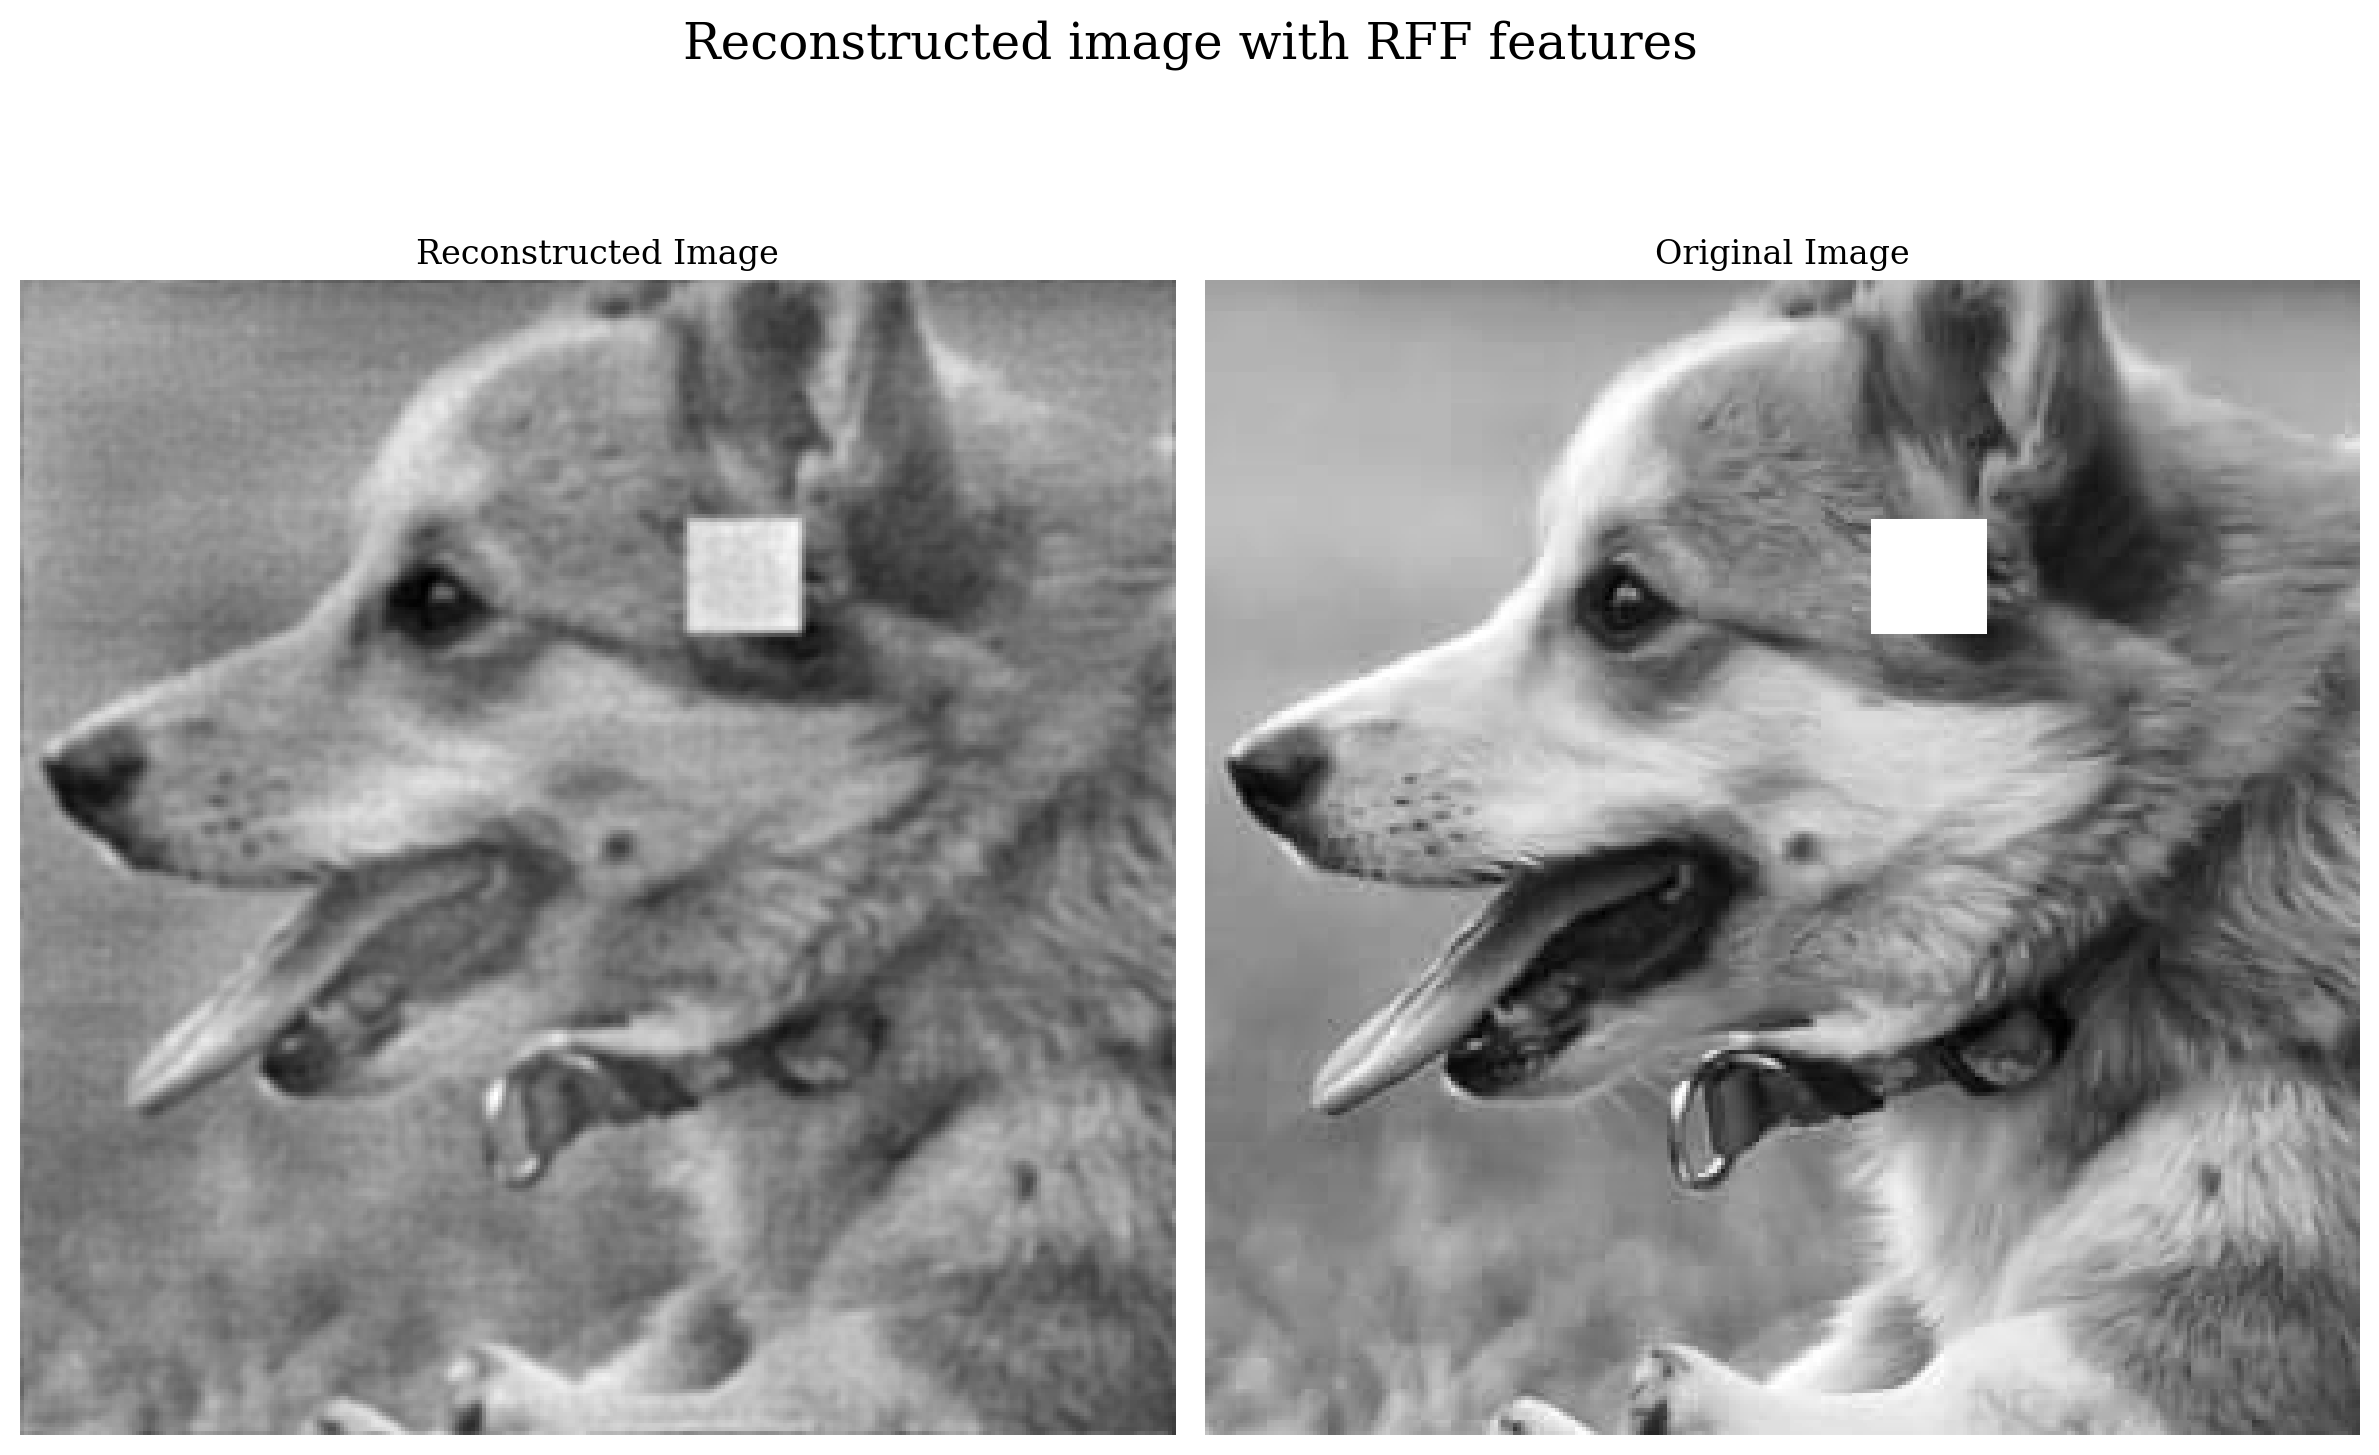

In [51]:
plot_reconstructed_and_original_image(removed_image.reshape(-1, 300, 300), net, X_rff, "Reconstructed image with RFF features")

## With Linear Regression and RFF
### RMSE:  tensor(59.9303)
### PSNR:  tensor(30.3543)
## With Matrix Factorization
### RMSE:  tensor(15.9023)
### PSNR:  tensor(36.1162)